In [1]:
# import threading

# import time

# from google.colab import output



# # define function to keep active

# def keep_alive():

#     while True:

#         time.sleep(60)  # refresh every 60 second

#         output.eval_js('google.colab.kernel.accessTokenHandler()')



# # avtive the thread

# thread = threading.Thread(target=keep_alive)

# thread.daemon = True

# thread.start()


In [2]:
#train model

In [3]:
!nvidia-smi


Tue Nov 26 03:37:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Step 1: Set up environment and download YOLOv5

!git clone https://github.com/ultralytics/yolov5  # Clone YOLOv5 repo

%cd yolov5

!pip install -r requirements.txt  # Install YOLOv5 requirements


Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 22), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 30.02 MiB/s, done.
Resolving deltas: 100% (11717/11717), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 24.5 MB/s eta 0:00:0000:01


In [6]:
# # Step 2: Install Kaggle API and authenticate

# !pip install kaggle



# # Upload your Kaggle API key

# from google.colab import files

# files.upload()  # Upload 'kaggle.json' file here



# # Move the Kaggle API key to the appropriate directory

# !mkdir -p ~/.kaggle

# !mv kaggle.json ~/.kaggle/

In [7]:
# Step 3: Download datasets from Kaggle

!kaggle datasets download -d bjoernjostein/food-classification -p ../datasets/food_classification --unzip

!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition -p ../datasets/fruit_and_veg --unzip

Dataset URL: https://www.kaggle.com/datasets/bjoernjostein/food-classification
License(s): CC0-1.0
 98%|████████████████████████████████████████ | 737M/753M [00:06<00:00, 160MB/s]
100%|█████████████████████████████████████████| 753M/753M [00:06<00:00, 121MB/s]
Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
 55%|█████████████████████▍                 | 1.09G/1.98G [00:09<00:06, 140MB/s]^C
 56%|█████████████████████▊                 | 1.11G/1.98G [00:09<00:07, 126MB/s]
User cancelled operation


In [8]:
# !kaggle datasets download -d bjoernjostein/food-classification -p ../datasets/food_classification --unzip

In [11]:
# import os
# import shutil
# import pandas as pd
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define paths
# food_dataset_path = '../datasets/food_classification'
# fruit_veg_dataset_path = '../datasets/fruit_and_veg'
# data_dir = '../datasets/combined_dataset'

# # Create combined dataset directory
# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)

# # Create subdirectories for YOLOv5
# image_dir = os.path.join(data_dir, 'images')
# label_dir = os.path.join(data_dir, 'labels')
# augmented_image_dir = os.path.join(data_dir, 'augmented_images')
# augmented_label_dir = os.path.join(data_dir, 'augmented_labels')
# temp_dir = os.path.join(data_dir, 'temp_class_dir')

# os.makedirs(image_dir, exist_ok=True)
# os.makedirs(label_dir, exist_ok=True)
# os.makedirs(augmented_image_dir, exist_ok=True)
# os.makedirs(augmented_label_dir, exist_ok=True)
# os.makedirs(temp_dir, exist_ok=True)

# # Step 1: Create a dynamic class map from the datasets
# class_map = {}  # A dictionary to hold unique classes and their corresponding IDs

# # SubStep 1: Process food_classification dataset
# def process_food_classification(src_path, image_dir, label_dir):
#     csv_path = os.path.join(src_path, 'train_img.csv')  # Path to the CSV file
#     df = pd.read_csv(csv_path)

#     global class_map
#     for _, row in df.iterrows():
#         image_id = row['ImageId']
#         class_name = row['ClassName']

#         # Add class to class_map if not already present
#         if class_name not in class_map:
#             class_map[class_name] = len(class_map)  # Assign a new ID to the class

#         # Copy image
#         src_image_path = os.path.join(src_path, 'train_images/train_images', image_id)
#         dst_image_path = os.path.join(image_dir, image_id)
#         shutil.copy(src_image_path, dst_image_path)

#         # Generate YOLO label file
#         class_id = class_map[class_name]
#         label_path = os.path.join(label_dir, os.path.splitext(image_id)[0] + '.txt')
#         with open(label_path, 'w') as f:
#             # Assuming normalized YOLO format (x_center, y_center, width, height)
#             f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

# # SubStep 2: Process fruit_and_vegetable_image_recognition dataset
# def process_fruit_veg(src_path, image_dir, label_dir):
#     global class_map
#     class_names = os.listdir(src_path)  # Class names are folder names
#     for class_name in class_names:
#         class_path = os.path.join(src_path, class_name)
#         if os.path.isdir(class_path):
#             # Add class to class_map if not already present
#             if class_name not in class_map:
#                 class_map[class_name] = len(class_map)  # Assign a new ID to the class

#             class_id = class_map[class_name]
#             for image_name in os.listdir(class_path):
#                 if image_name.endswith(('.jpg', '.png', '.jpeg')):
#                     src_image_path = os.path.join(class_path, image_name)
#                     dst_image_path = os.path.join(image_dir, image_name)
#                     shutil.copy(src_image_path, dst_image_path)

#                     # Generate YOLO label file
#                     label_path = os.path.join(label_dir, os.path.splitext(image_name)[0] + '.txt')
#                     with open(label_path, 'w') as f:
#                         f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

# # Step 2: Prepare temporary directory for augmentation
# def prepare_temp_dir(image_dir, temp_dir, class_map):
#     if not os.path.exists(temp_dir):
#         os.makedirs(temp_dir)
#     for class_name, class_id in class_map.items():
#         class_folder = os.path.join(temp_dir, class_name)
#         os.makedirs(class_folder, exist_ok=True)

#     for image_file in os.listdir(image_dir):
#         class_id = None
#         for class_name, class_map_id in class_map.items():
#             if f"{class_map_id}" in image_file:  # Match class ID in file name
#                 class_id = class_map_id
#                 break

#         if class_id is not None:
#             class_folder = os.path.join(temp_dir, class_name)
#             shutil.copy(
#                 os.path.join(image_dir, image_file),
#                 os.path.join(class_folder, image_file),
#             )

# # Step 3: Apply data augmentation
# def augment_images(temp_dir, augmented_image_dir):
#     datagen = ImageDataGenerator(
#         rescale=1.0 / 255,  # Normalize pixel values
#         rotation_range=30,  # Rotate images
#         width_shift_range=0.2,  # Shift width
#         height_shift_range=0.2,  # Shift height
#         shear_range=0.15,  # Shear transformation
#         zoom_range=0.2,  # Zoom transformation
#         fill_mode="nearest",  # Fill missing pixels
#     )

#     for class_name in os.listdir(temp_dir):
#         class_folder = os.path.join(temp_dir, class_name)
#         save_folder = os.path.join(augmented_image_dir, class_name)
#         os.makedirs(save_folder, exist_ok=True)

#         for img_batch in datagen.flow_from_directory(
#             temp_dir,
#             batch_size=32,
#             target_size=(224, 224),
#             class_mode=None,
#             save_to_dir=save_folder,
#             save_format="jpeg",
#         ):
#             break  # Process one batch per class

# # Prepare data
# process_food_classification(food_dataset_path, image_dir, label_dir)
# process_fruit_veg(fruit_veg_dataset_path, image_dir, label_dir)

# # Prepare temp directory for augmentation
# prepare_temp_dir(image_dir, temp_dir, class_map)

# # Apply data augmentation
# augment_images(temp_dir, augmented_image_dir)

# # Save class_map to a file for reference
# with open(os.path.join(data_dir, 'classes.txt'), 'w') as f:
#     for class_name, class_id in sorted(class_map.items(), key=lambda x: x[1]):
#         f.write(f"{class_id}: {class_name}\n")

# print("Datasets processed and augmented for YOLO format!")
# print(f"Class map:\n{class_map}")


Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 images belonging to 61 classes.
Found 9323 

In [12]:
# step 4 prepare dataset

import os
import shutil
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
food_dataset_path = '../datasets/food_classification'
fruit_veg_dataset_path = '../datasets/fruit_and_veg'
data_dir = '../datasets/combined_dataset'

# Create combined dataset directory
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Create subdirectories for YOLOv5
image_dir = os.path.join(data_dir, 'images')
label_dir = os.path.join(data_dir, 'labels')
augmented_image_dir = os.path.join(data_dir, 'augmented_images')
augmented_label_dir = os.path.join(data_dir, 'augmented_labels')
temp_dir = os.path.join(data_dir, 'temp_class_dir')

os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)
os.makedirs(augmented_image_dir, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)

# Step 1: Create a dynamic class map from the datasets
class_map = {}  # A dictionary to hold unique classes and their corresponding IDs

# SubStep 1: Process food_classification dataset
def process_food_classification(src_path, image_dir, label_dir):
    csv_path = os.path.join(src_path, 'train_img.csv')  # Path to the CSV file
    df = pd.read_csv(csv_path)

    global class_map
    for _, row in df.iterrows():
        image_id = row['ImageId']
        class_name = row['ClassName']

        # Add class to class_map if not already present
        if class_name not in class_map:
            class_map[class_name] = len(class_map)  # Assign a new ID to the class

        # Copy image
        src_image_path = os.path.join(src_path, 'train_images/train_images', image_id)
        dst_image_path = os.path.join(image_dir, image_id)
        shutil.copy(src_image_path, dst_image_path)

        # Generate YOLO label file
        class_id = class_map[class_name]
        label_path = os.path.join(label_dir, os.path.splitext(image_id)[0] + '.txt')
        with open(label_path, 'w') as f:
            # Assuming normalized YOLO format (x_center, y_center, width, height)
            f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

# SubStep 2: Process fruit_and_vegetable_image_recognition dataset
def process_fruit_veg(src_path, image_dir, label_dir):
    global class_map
    class_names = os.listdir(src_path)  # Class names are folder names
    for class_name in class_names:
        class_path = os.path.join(src_path, class_name)
        if os.path.isdir(class_path):
            # Add class to class_map if not already present
            if class_name not in class_map:
                class_map[class_name] = len(class_map)  # Assign a new ID to the class

            class_id = class_map[class_name]
            for image_name in os.listdir(class_path):
                if image_name.endswith(('.jpg', '.png', '.jpeg')):
                    src_image_path = os.path.join(class_path, image_name)
                    dst_image_path = os.path.join(image_dir, image_name)
                    shutil.copy(src_image_path, dst_image_path)

                    # Generate YOLO label file
                    label_path = os.path.join(label_dir, os.path.splitext(image_name)[0] + '.txt')
                    with open(label_path, 'w') as f:
                        f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

# Step 2: Prepare temporary directory for augmentation
def prepare_temp_dir(image_dir, temp_dir, class_map):
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
    for class_name, class_id in class_map.items():
        class_folder = os.path.join(temp_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)

    for image_file in os.listdir(image_dir):
        class_id = None
        for class_name, class_map_id in class_map.items():
            if f"{class_map_id}" in image_file:  # Match class ID in file name
                class_id = class_map_id
                break

        if class_id is not None:
            class_folder = os.path.join(temp_dir, class_name)
            shutil.copy(
                os.path.join(image_dir, image_file),
                os.path.join(class_folder, image_file),
            )

# Step 3: Apply data augmentation
def augment_images(temp_dir, augmented_image_dir):
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,  # Normalize pixel values
        rotation_range=30,  # Rotate images
        width_shift_range=0.2,  # Shift width
        height_shift_range=0.2,  # Shift height
        shear_range=0.15,  # Shear transformation
        zoom_range=0.2,  # Zoom transformation
        fill_mode="nearest",  # Fill missing pixels
    )

    # Process the entire directory at once
    print(f"Augmenting images from {temp_dir}...")
    generator = datagen.flow_from_directory(
        temp_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        save_to_dir=augmented_image_dir,
        save_prefix="aug",
        save_format="jpeg",
    )

    # Generate augmented images (limit to a fixed number if needed)
    total_batches = 100  # Set an upper limit to prevent infinite loops
    for i, _ in enumerate(generator):
        if i >= total_batches:
            break  # Stop after processing enough batches
    print("Augmentation completed!")

# Prepare data
process_food_classification(food_dataset_path, image_dir, label_dir)
process_fruit_veg(fruit_veg_dataset_path, image_dir, label_dir)

# Prepare temp directory for augmentation
prepare_temp_dir(image_dir, temp_dir, class_map)

# Apply data augmentation
augment_images(temp_dir, augmented_image_dir)

# Save class_map to a file for reference
with open(os.path.join(data_dir, 'classes.txt'), 'w') as f:
    for class_name, class_id in sorted(class_map.items(), key=lambda x: x[1]):
        f.write(f"{class_id}: {class_name}\n")

print("Datasets processed and augmented for YOLO format!")
print(f"Class map:\n{class_map}")


Augmenting images from ../datasets/combined_dataset/temp_class_dir...
Found 9323 images belonging to 61 classes.
Augmentation completed!
Datasets processed and augmented for YOLO format!
Class map:
{'water': 0, 'pizza-margherita-baked': 1, 'broccoli': 2, 'salad-leaf-salad-green': 3, 'egg': 4, 'butter': 5, 'bread-white': 6, 'apple': 7, 'dark-chocolate': 8, 'white-coffee-with-caffeine': 9, 'sweet-pepper': 10, 'mixed-salad-chopped-without-sauce': 11, 'tomato-sauce': 12, 'cucumber': 13, 'cheese': 14, 'pasta-spaghetti': 15, 'rice': 16, 'zucchini': 17, 'salmon': 18, 'mixed-vegetables': 19, 'espresso-with-caffeine': 20, 'banana': 21, 'strawberries': 22, 'mayonnaise': 23, 'almonds': 24, 'bread-wholemeal': 25, 'wine-white': 26, 'hard-cheese': 27, 'ham-raw': 28, 'tomato': 29, 'french-beans': 30, 'mandarine': 31, 'wine-red': 32, 'potatoes-steamed': 33, 'croissant': 34, 'carrot': 35, 'salami': 36, 'boisson-au-glucose-50g': 37, 'biscuits': 38, 'corn': 39, 'leaf-spinach': 40, 'tea-green': 41, 'chips

In [13]:
# Step 5: Create a YOLOv5 configuration file

import yaml

import os



# use the class_map created before

class_map_file = os.path.join(data_dir, 'classes.txt')

class_map = {}



# read class_map and fill the mapping of class_id and class_name

with open(class_map_file, 'r') as f:

    for line in f:

        class_id, class_name = line.strip().split(': ')

        class_map[int(class_id)] = class_name



# make sure the order of class_id

class_ids = sorted(class_map.keys())

nc = len(class_ids)  # total number of classes



# create names according to class+map

names = [class_map[class_id] for class_id in class_ids]



# Create YOLOv5 configuration file

config = {

    'train': os.path.join(data_dir, 'images'),

    'val': os.path.join(data_dir, 'images'),

    'nc': nc,  # total number of classes

    'names': names  # total number of names

}



# Write configuration to YAML file

config_file_path = 'data/food.yaml'

os.makedirs(os.path.dirname(config_file_path), exist_ok=True)



with open(config_file_path, 'w') as file:

    yaml.dump(config, file, default_flow_style=False)



print(f"YOLOv5 configuration file created at {config_file_path}")

print(f"Number of classes (nc): {nc}")

print(f"Class names (names): {names}")


YOLOv5 configuration file created at data/food.yaml
Number of classes (nc): 61
Class names (names): ['water', 'pizza-margherita-baked', 'broccoli', 'salad-leaf-salad-green', 'egg', 'butter', 'bread-white', 'apple', 'dark-chocolate', 'white-coffee-with-caffeine', 'sweet-pepper', 'mixed-salad-chopped-without-sauce', 'tomato-sauce', 'cucumber', 'cheese', 'pasta-spaghetti', 'rice', 'zucchini', 'salmon', 'mixed-vegetables', 'espresso-with-caffeine', 'banana', 'strawberries', 'mayonnaise', 'almonds', 'bread-wholemeal', 'wine-white', 'hard-cheese', 'ham-raw', 'tomato', 'french-beans', 'mandarine', 'wine-red', 'potatoes-steamed', 'croissant', 'carrot', 'salami', 'boisson-au-glucose-50g', 'biscuits', 'corn', 'leaf-spinach', 'tea-green', 'chips-french-fries', 'parmesan', 'beer', 'bread-french-white-flour', 'coffee-with-caffeine', 'chicken', 'soft-cheese', 'tea', 'avocado', 'bread-sourdough', 'gruyere', 'sauce-savoury', 'honey', 'mixed-nuts', 'jam', 'bread-whole-wheat', 'water-mineral', 'onion', 

In [14]:
!python train.py --weights yolov5s.pt --data data/food.yaml --epochs 30 --batch-size 64 --imgsz 640 --workers 8 --optimizer AdamW --device 0


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=data/food.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolv

Confusion Matrix:
                        water  pizza-margherita-baked  broccoli  \
water                     129                       2         2   
pizza-margherita-baked      2                     412         1   
broccoli                    1                       1       773   
salad-leaf-salad-green      1                       1         1   
egg                         0                       0         1   
...                       ...                     ...       ...   
jam                         1                       1         1   
bread-whole-wheat           0                       1         0   
water-mineral               1                       0         2   
onion                       1                       1         0   
pickle                      3                       1         3   

                        salad-leaf-salad-green  egg  butter  bread-white  \
water                                        1    0       0            0   
pizza-margherita-baked   

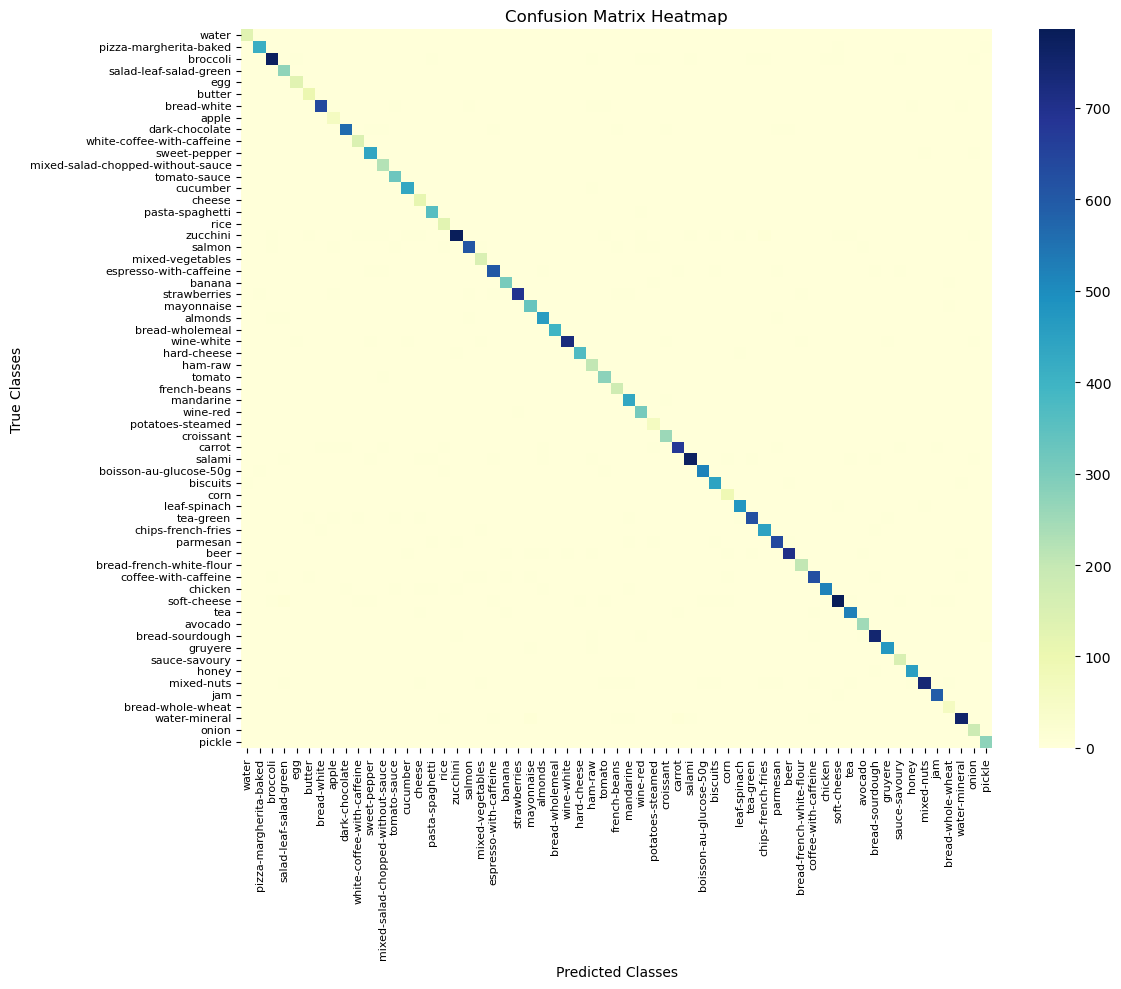

In [1]:
# import numpy as np
# from sklearn.metrics import precision_recall_curve, average_precision_score
# from sklearn.model_selection import train_test_split
# import torch
# from torch.utils.data import DataLoader
# from models.common import DetectMultiBackend  # YOLOv5 model
# from utils.general import non_max_suppression
# from utils.torch_utils import select_device
# from utils.dataloaders import LoadImagesAndLabels  # Import YOLOv5's dataset loader
# from utils.dataloaders import create_dataloader
# import os
# import shutil

# # Define paths for the combined dataset
# data_dir = '../datasets/combined_dataset'
# image_dir = os.path.join(data_dir, 'images')
# label_dir = os.path.join(data_dir, 'labels')
# train_image_dir = os.path.join(data_dir, 'train/images')
# train_label_dir = os.path.join(data_dir, 'train/labels')
# val_image_dir = os.path.join(data_dir, 'val/images')
# val_label_dir = os.path.join(data_dir, 'val/labels')

# # Create directories
# os.makedirs(train_image_dir, exist_ok=True)
# os.makedirs(train_label_dir, exist_ok=True)
# os.makedirs(val_image_dir, exist_ok=True)
# os.makedirs(val_label_dir, exist_ok=True)

# # Split dataset into training and validation
# image_files = os.listdir(image_dir)
# label_files = os.listdir(label_dir)

# # Ensure corresponding label files exist
# image_files = [f for f in image_files if os.path.splitext(f)[0] + '.txt' in label_files]

# # Split into train and validation sets
# train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# # Move files to their respective directories
# for file in train_files:
#     shutil.copy(os.path.join(image_dir, file), os.path.join(train_image_dir, file))
#     shutil.copy(os.path.join(label_dir, os.path.splitext(file)[0] + '.txt'), os.path.join(train_label_dir, os.path.splitext(file)[0] + '.txt'))

# for file in val_files:
#     shutil.copy(os.path.join(image_dir, file), os.path.join(val_image_dir, file))
#     shutil.copy(os.path.join(label_dir, os.path.splitext(file)[0] + '.txt'), os.path.join(val_label_dir, os.path.splitext(file)[0] + '.txt'))

# print(f"Training data saved to {train_image_dir} and {train_label_dir}")
# print(f"Validation data saved to {val_image_dir} and {val_label_dir}")

# # Function to calculate IoU
# def calculate_iou(box1, box2):
#     """Compute IoU between two bounding boxes."""
#     x1 = max(box1[0], box2[0])
#     y1 = max(box1[1], box2[1])
#     x2 = min(box1[2], box2[2])
#     y2 = min(box1[3], box2[3])

#     intersection = max(0, x2 - x1) * max(0, y2 - y1)
#     box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
#     box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
#     union = box1_area + box2_area - intersection

#     return intersection / union if union > 0 else 0

# # Function to compute evaluation metrics
# def compute_metrics(predictions, ground_truths, iou_threshold=0.5):
#     """Compute Precision, Recall, and F1 Score."""
#     true_positives = 0
#     false_positives = 0
#     false_negatives = len(ground_truths)

#     for pred_box, pred_class in predictions:
#         matched = False
#         for gt_box, gt_class in ground_truths:
#             if pred_class == gt_class and calculate_iou(pred_box, gt_box) >= iou_threshold:
#                 true_positives += 1
#                 false_negatives -= 1
#                 matched = True
#                 break
#         if not matched:
#             false_positives += 1

#     precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
#     recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
#     f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

#     return precision, recall, f1_score

# # Function to compute Mean Average Precision (mAP)
# def compute_map(predictions, ground_truths, num_classes, iou_threshold=0.5):
#     """Compute Mean Average Precision."""
#     ap_per_class = []

#     for cls in range(num_classes):
#         # Extract predictions and ground truths for this class
#         pred_class_boxes = [pred[0] for pred in predictions if pred[1] == cls]
#         gt_class_boxes = [gt[0] for gt in ground_truths if gt[1] == cls]

#         # Match predictions with ground truths
#         y_true = []
#         y_score = []

#         for pred_box in pred_class_boxes:
#             matched = False
#             for gt_box in gt_class_boxes:
#                 if calculate_iou(pred_box, gt_box) >= iou_threshold:
#                     y_true.append(1)  # True positive
#                     matched = True
#                     break
#             if not matched:
#                 y_true.append(0)  # False positive
#             y_score.append(1)  # Confidence score (assume 1 for simplicity)

#         # Ground truths not matched by any predictions are false negatives
#         for _ in range(len(gt_class_boxes) - sum(y_true)):
#             y_true.append(1)  # False negatives
#             y_score.append(0)  # No confidence for missed ground truths

#         # Calculate average precision for this class
#         if len(y_true) > 0:
#             ap = average_precision_score(y_true, y_score)
#             ap_per_class.append(ap)

#     # Return mean AP across all classes
#     return np.mean(ap_per_class) if ap_per_class else 0


# # Example usage during validation
# def validate_model(val_loader, model, num_classes, iou_threshold=0.5):
#     """Validate the YOLOv5 model and compute metrics."""
#     all_predictions = []
#     all_ground_truths = []

#     for batch in val_loader:
#         images, targets, paths, shapes = batch  # Unpack the dataloader output

#         # Normalize and convert images to float32
#         images = images.float() / 255.0  # Normalize to [0, 1]

#         # Move images to the same device as the model
#         device = next(model.parameters()).device
#         images = images.to(device)

#         # Get predictions from the model
#         predictions = model(images)  # Run inference on the batch
#         predictions = non_max_suppression(predictions, conf_thres=0.25, iou_thres=0.45)  # Apply NMS

#         # Convert predictions to the required format
#         predictions_formatted = []
#         for pred in predictions:
#             if pred is not None:  # Ensure predictions exist
#                 for *box, conf, cls in pred:
#                     predictions_formatted.append((box, int(cls)))

#         # Convert targets to the required format
#         ground_truths_formatted = []
#         for target in targets:
#             box = target[2:6]  # YOLOv5 format: (image_idx, class, x_center, y_center, width, height)
#             cls = int(target[1])
#             ground_truths_formatted.append((box, cls))

#         all_predictions.extend(predictions_formatted)
#         all_ground_truths.extend(ground_truths_formatted)

#     # Compute metrics
#     precision, recall, f1_score = compute_metrics(all_predictions, all_ground_truths, iou_threshold)
#     map_score = compute_map(all_predictions, all_ground_truths, num_classes, iou_threshold)

#     print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}")
#     print(f"Mean Average Precision (mAP): {map_score:.2f}")




# # Integrate this into the YOLOv5 training script
# if __name__ == "__main__":
#     # Load validation dataset using create_dataloader
#     val_loader, _ = create_dataloader(
#         path=os.path.dirname(val_image_dir),  # Root dataset directory
#         imgsz=640,  # Image size for YOLOv5
#         batch_size=8,  # Batch size
#         stride=32,  # YOLOv5 stride
#         single_cls=False,  # Multi-class dataset
#         hyp=None,  # Use default hyperparameters
#         augment=False,  # No augmentation for validation
#         cache=False,  # Disable caching
#         rect=True,  # Enable rectangular inference
#         workers=4  # Number of workers
#     )

#     # Initialize YOLOv5 model
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model_path = 'runs/train/exp/weights/best.pt'  # Replace with the path to your YOLOv5 weights
#     model = DetectMultiBackend(model_path, device=device)
#     model.warmup(imgsz=(1, 3, 640, 640))  # Prewarm model

#     # Number of classes
#     class_map_file = os.path.join(data_dir, 'classes.txt')
#     with open(class_map_file, 'r') as f:
#         num_classes = len(f.readlines())

#     validate_model(val_loader, model, num_classes)


In [ ]:
# use model

from yolov5 import detect



# setting model use parameters

model_path = 'runs/train/exp/weights/best.pt'  # use best weight (use proper path)

source_image = '/path/to/test_image.jpg'       # use proper path to predicted image



# excute the image identifying

!python detect.py --weights {model_path} --img 640 --conf 0.5 --source {source_image}
